In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rc("figure", **{"figsize": (16,10)})
np.random.seed(27182)

from ou_market_making import OrnsteinUhlenbeck, PriceProcess

# Intuition

#### Ornstein–Uhlenbeck Process

$$\begin{aligned}
    \text{The }&\text{continuous case:} \\
    dX_t &= \theta(\mu-X_t)dt + \sigma dB_t \\
    X_{t_{i+1}} &= X_{t_i} + \int_{t_i}^{t_{i+1}} \theta(\mu-X_s)ds + \int_{t_i}^{t_{i+1}} \sigma dB_s \\
    \text{The }&\text{discrete case:} \\
    \Delta X_{t_i} &= \theta(\mu-X_{t_i})\Delta t + \sigma \Delta B_{t_i} \\
    X_{t_{i+1}} &= X_{t_i} + \Delta X_{t_i}
\end{aligned}$$

In [2]:
# GLOBALS

N_STEPS = int(1e3)
X0 = 10

TICKSIZE = 0.1

# Set up parameters from above
theta  = 7
mu     = X0
sigma  = 3
deltat = 1e-2

# new params
# N_STEPS = int(1e3)
X0 = 0

# TICKSIZE = 0.01

# theta  = 3
mu     = X0
# sigma  = 5
# deltat = 1e-4

ou = OrnsteinUhlenbeck(X0, theta, mu, sigma, deltat)
pripro = PriceProcess(ou, TICKSIZE)

pripro.generate(N_STEPS)

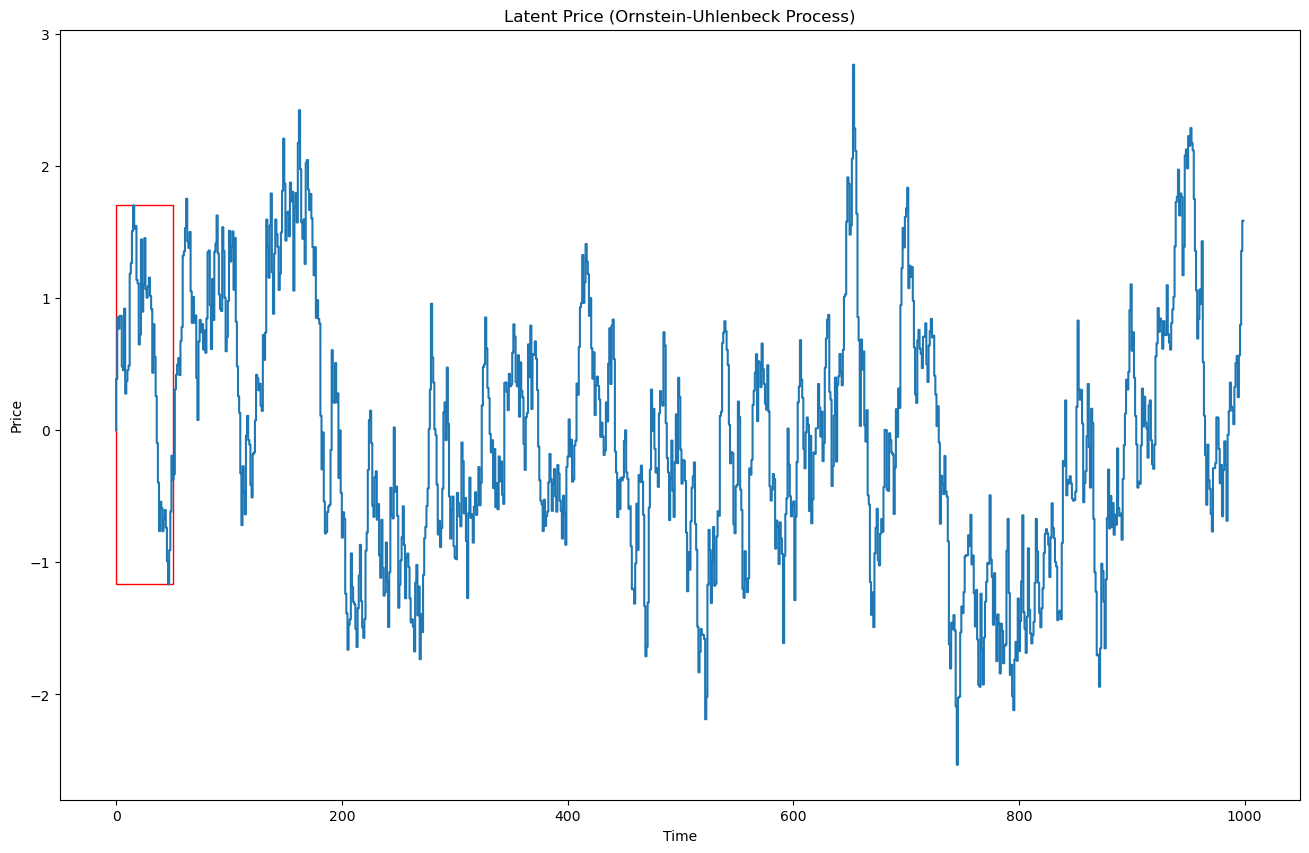

In [3]:
N_FIRST = 50

slice = pripro.time < N_FIRST
temp_latent_price = pripro.latent_price[slice]
lo, hi = temp_latent_price.min(), temp_latent_price.max()

fig, axis = plt.subplots()

pripro.plot_latent_price(axis)
axis.add_patch(Rectangle((0, lo), N_FIRST, hi-lo, edgecolor='r', fill=False))

plt.show()

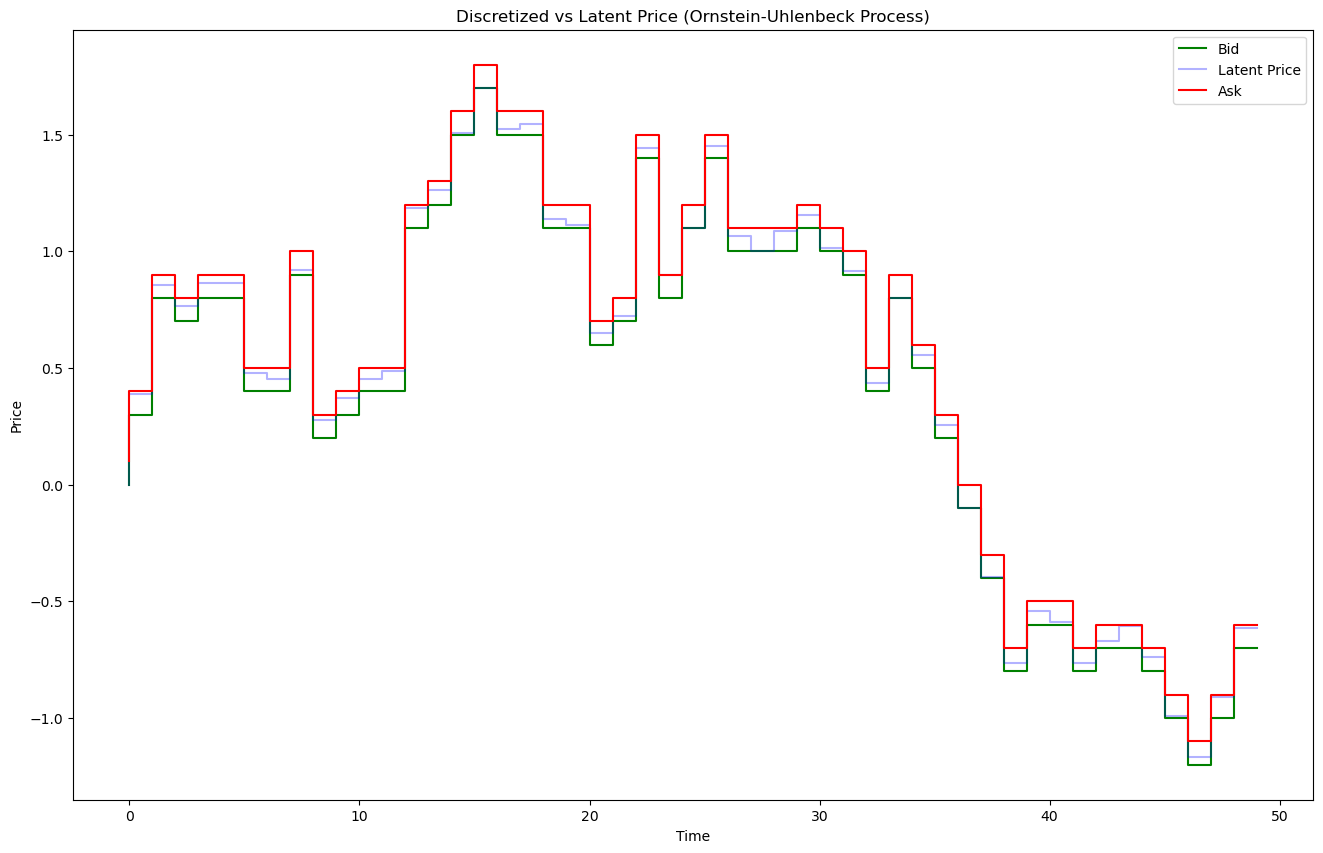

In [4]:
fig, axis = plt.subplots()

pripro.plot_bid_ask(axis, slice)

plt.show()

# Intuition

Given the difference equation, we can estimate where 

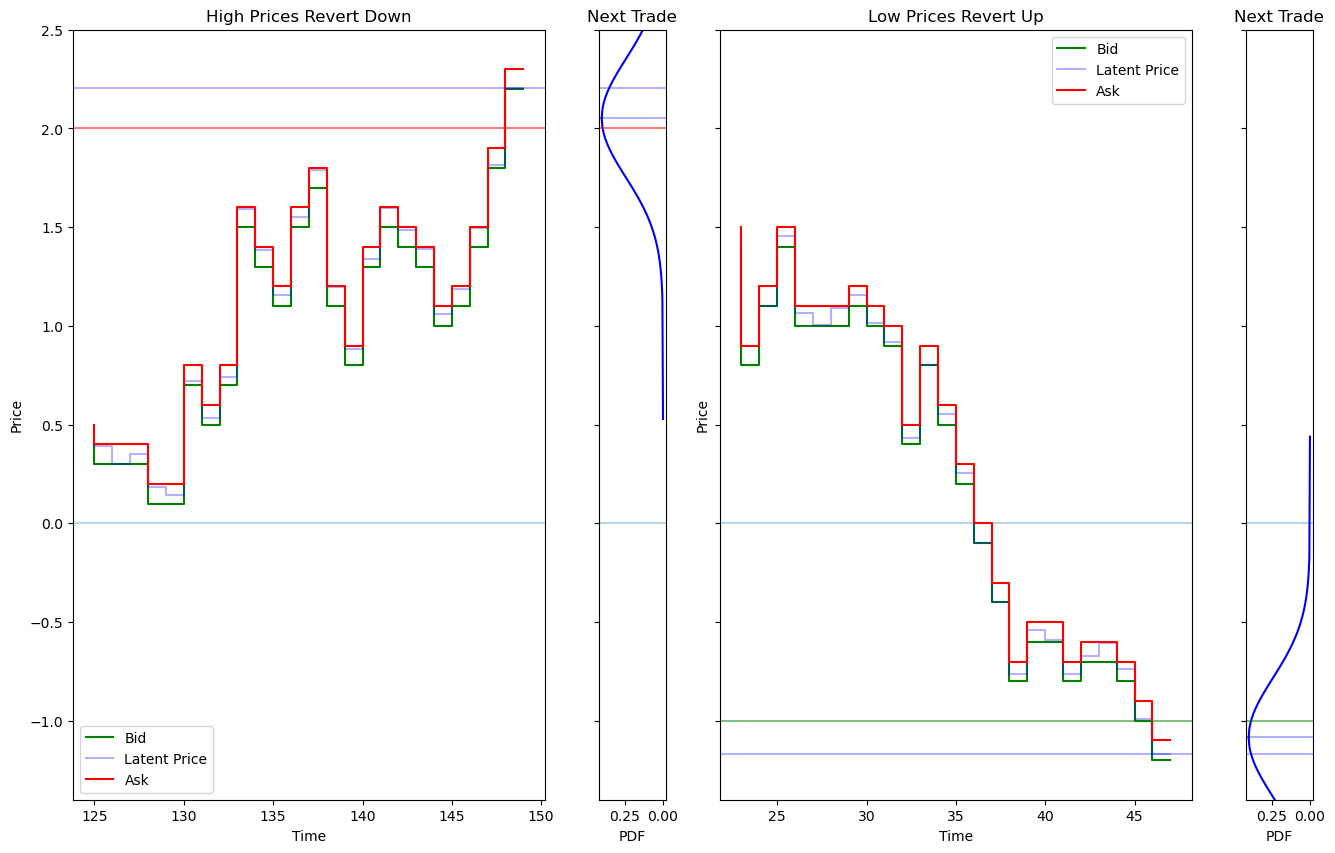

In [5]:
slice = N_FIRST / 2

hi_bound = X0 + 20*TICKSIZE
lo_bound = X0 - 10*TICKSIZE

hi_loc = np.argmax(pripro.latent_price>hi_bound)
lo_loc = np.argmax(pripro.latent_price<lo_bound)
hi_latent = pripro.latent_price[hi_loc]
lo_latent = pripro.latent_price[lo_loc]

fig, axs = plt.subplots(1, 4, gridspec_kw={"width_ratios": [7,1,7,1]}, sharey=True)

for axx in axs:
    axx.axhline(X0, alpha=0.3)

pripro.plot_bid_ask(axs[0], (hi_loc-slice < pripro.time) & (pripro.time <= hi_loc))
axs[0].axhline(hi_bound, color='r', alpha=0.5)
axs[0].axhline(hi_latent, color='b', alpha=0.3)
axs[0].set(title="High Prices Revert Down")

pripro.dynamics.plot_next_pdf(axs[1], hi_latent)
axs[1].axhline(hi_bound, color='r', alpha=0.5)
axs[1].axhline(hi_latent, color='b', alpha=0.3)
axs[1].set(title="Next Trade", xlabel="PDF")

pripro.plot_bid_ask(axs[2], (lo_loc-slice < pripro.time) & (pripro.time <= lo_loc))
axs[2].axhline(lo_bound, color='g', alpha=0.5)
axs[2].axhline(lo_latent, color='b', alpha=0.3)
axs[2].set(title="Low Prices Revert Up")

pripro.dynamics.plot_next_pdf(axs[3], lo_latent)
axs[3].axhline(lo_bound, color='g', alpha=0.5)
axs[3].axhline(lo_latent, color='b', alpha=0.3)
axs[3].set(title="Next Trade", xlabel="PDF")

axs[0].set_ylabel("Price")
axs[3].set_ylim([pripro.bid_price[lo_loc]-2*TICKSIZE, pripro.ask_price[hi_loc]+2*TICKSIZE])
plt.show()

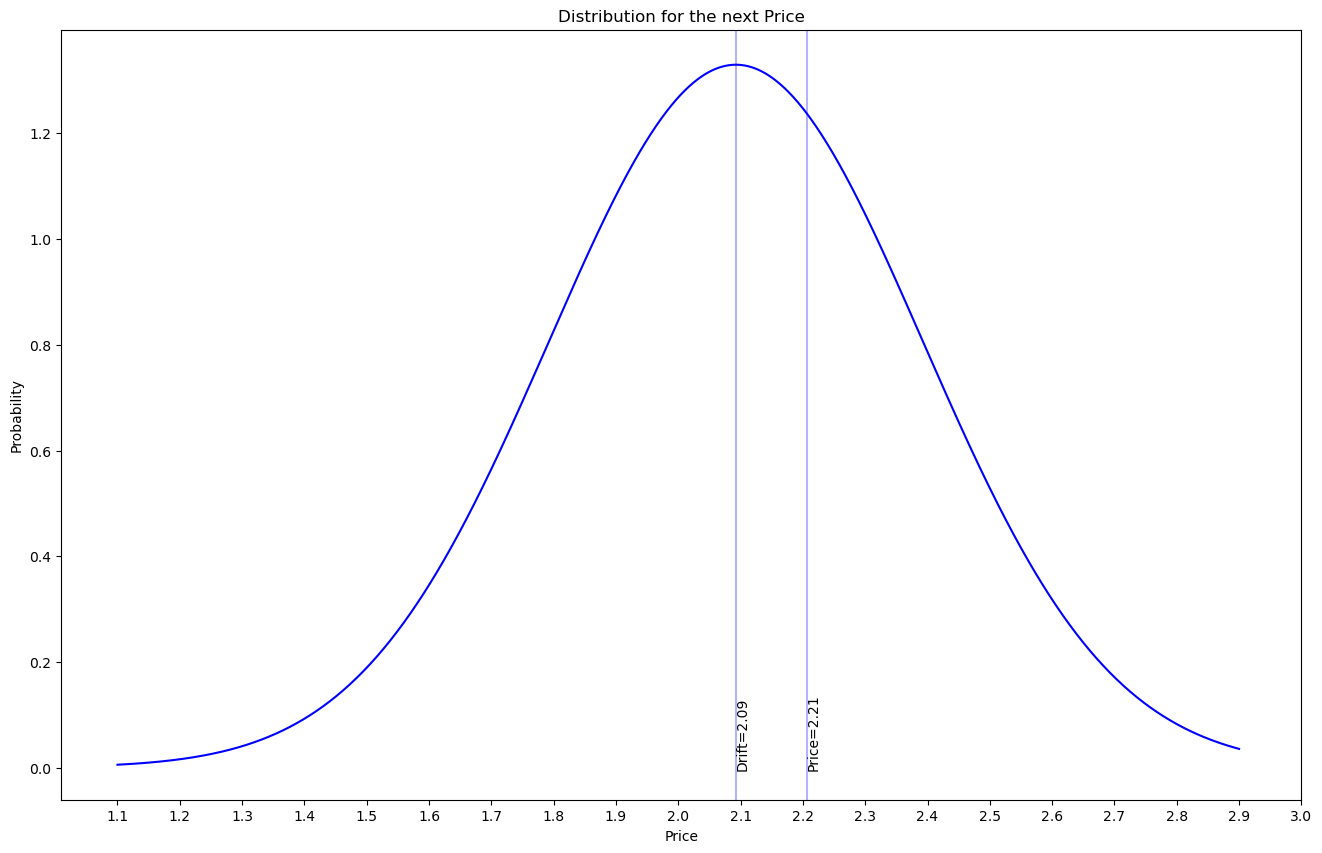

In [6]:
def round_to(x: float, rounder: float) -> float:
    return (x // rounder) * rounder

hi_bid = round_to(hi_latent, TICKSIZE)
hi_mid = hi_bid + TICKSIZE / 2
hi_ask = hi_bid + TICKSIZE

hi_drift = pripro.dynamics.theta * (pripro.dynamics.mu - hi_mid) * pripro.dynamics.deltat
hi_mean = hi_mid + hi_drift
std = pripro.dynamics.sigma * pripro.dynamics.deltat**0.5

prices = np.linspace(round_to(hi_mean - std * 3, TICKSIZE), round_to(hi_mean + std * 3, TICKSIZE), 1000)
pdf = stats.norm.pdf(prices, hi_mean, std)

fig, axs = plt.subplots()
axs.plot(prices, pdf, color='b')
axs.axvline(hi_mean, color='b', alpha=0.3)
axs.axvline(hi_latent, color='b', alpha=0.3)

axs.text(hi_latent, 0, f"Price={hi_latent:.2f}", rotation=90)
axs.text(hi_mean, 0, f"Drift={hi_mean:.2f}", rotation=90)

xti = np.round(np.arange(prices.min(), prices.max()+TICKSIZE, TICKSIZE), 2)

axs.set(title="Distribution for the next Price", xlabel="Price", ylabel="Probability", xticks=xti, xticklabels=xti)

plt.show()

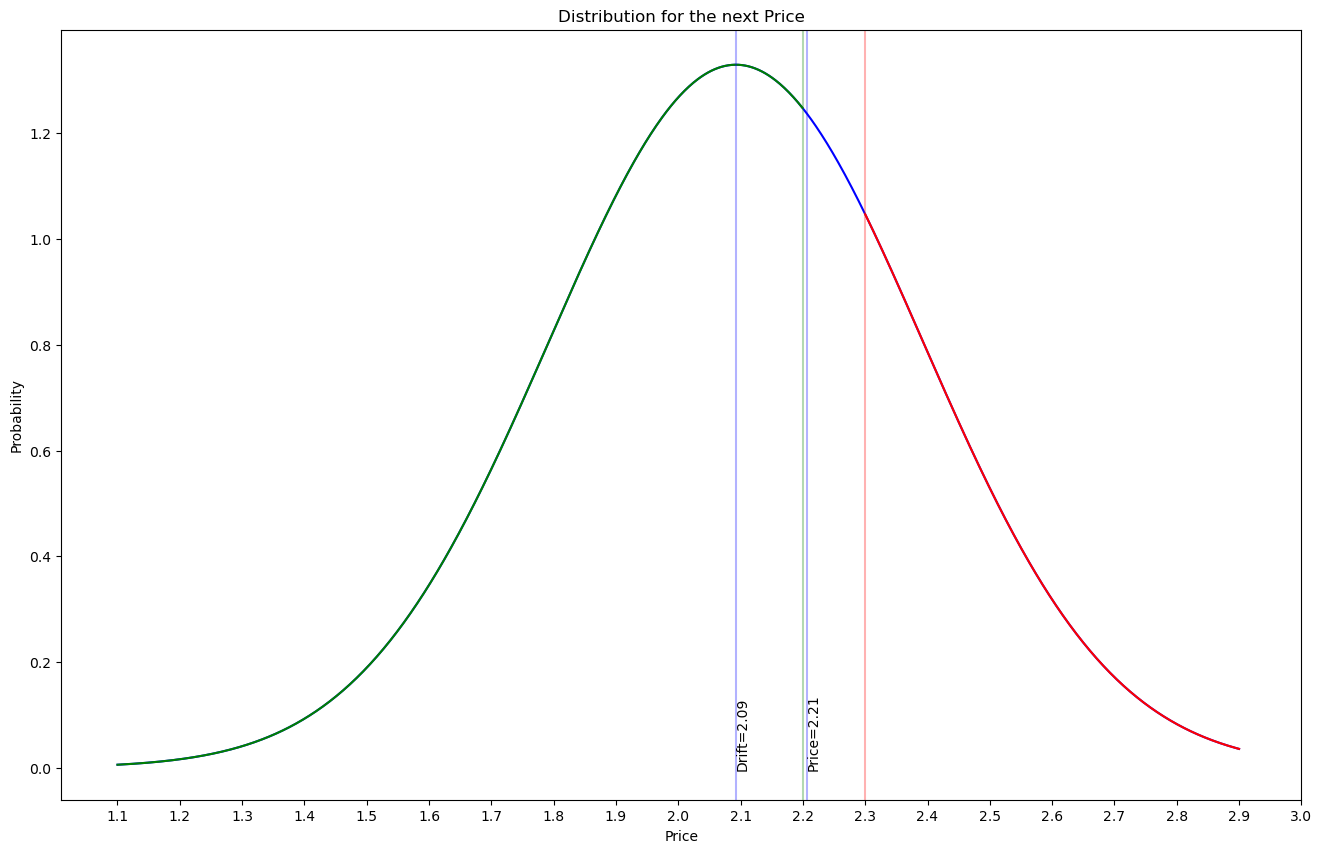

In [7]:
mask_do = prices <= hi_bid
mask_up = hi_ask <= prices

fig, axs = plt.subplots()

axs.plot(prices, pdf, color='b')
axs.plot(prices[mask_do], pdf[mask_do], color='g')
axs.plot(prices[mask_up], pdf[mask_up], color='r')
axs.axvline(hi_mean, color='b', alpha=0.3)
axs.axvline(hi_latent, color='b', alpha=0.3)
axs.axvline(hi_bid, color='g', alpha=0.3)
axs.axvline(hi_ask, color='r', alpha=0.3)

axs.text(hi_latent, 0, f"Price={hi_latent:.2f}", rotation=90)
axs.text(hi_mean, 0, f"Drift={hi_mean:.2f}", rotation=90)

axs.set(title="Distribution for the next Price", xlabel="Price", ylabel="Probability", xticks=xti, xticklabels=xti)

plt.show()

In [121]:
from abc import ABC, abstractclassmethod
from numpy.typing import NDArray
import pandas as pd


def kelly_criterion(p: float | NDArray, q: float | NDArray, a: float | NDArray, b: float | NDArray) -> float | NDArray:
    return p/a - q/b

class TradingStrategy(ABC):

    exposure: float

    @abstractclassmethod
    def backtest(self):
        pass

    @abstractclassmethod
    def size_position(self):
        pass


class MeanRevertingStrategy(TradingStrategy):
    """Trades a PriceProcess based on understanding the OU Process's dynamics"""

    def __init__(self, pripro: PriceProcess, margin: float = 10, exposure: float = 1e4, z_score: float = 3):
        self.pripro = pripro
        self.margin = margin
        self.exposure = exposure
        self.data = pd.DataFrame()

        self.generate_sizing_factors(z_score)
        self.generate_kelly_pos()

    def backtest(self):
        self.positions = np.zeros(self.pripro.time.shape[0])

        price_arr = np.zeros(self.pripro.time.shape)
        pos_arr = np.zeros(self.pripro.time.shape)
        cash_arr = np.zeros(self.pripro.time.shape)

        cash = 0

        last_mid = self.pripro.dynamics.X0
        last_pos = 0

        for time in self.pripro.time:
            mid = pripro.mid_price[time]

            state = self.data.loc[(np.isclose(self.data["MID"], mid))]
            pos = state["POS"].values[0]

            price_arr[time] = mid
            pos_arr[time] = pos

            if   last_mid < mid: ind = 1 # up move
            elif mid < last_mid: ind = -1
            else: ind = 0

            if ind==1:
                mask = ((last_mid - self.pripro.ticksize / 10 < self.data["MID"])
                         & (self.data["MID"] < mid + self.pripro.ticksize / 10))
                
                dps = self.data[mask]
                trades = dps["ASK"].values[1:] @ dps["N@ASK"].values[1:]
            elif ind==-1:
                mask = ((mid - self.pripro.ticksize / 10 < self.data["MID"])
                         & (self.data["MID"] < last_mid + self.pripro.ticksize / 10))
                
                dps = self.data[mask]
                trades = dps["BID"].values[:-1] @ dps["N@BID"].values[:-1]
            else:
                trades = 0

            cash += -trades # + mtm
            cash_arr[time] = -trades

            last_mid = mid
            last_pos = pos

        self.trades = pd.DataFrame({"PRICE": price_arr, "POS": pos_arr, "CASH": cash_arr})

    def size_position(self, mid: float):
        pass

    def generate_sizing_factors(self, z_score: float) -> None:
        self.data["BID"] = np.arange(X0 - z_score * self.pripro.dynamics.sigma,
                                     X0 + z_score * self.pripro.dynamics.sigma,
                                     self.pripro.ticksize)
        self.data["MID"] = self.data["BID"] + self.pripro.ticksize / 2
        self.data["ASK"] = self.data["BID"] + self.pripro.ticksize

        self.data["EDO"] = np.zeros(self.data["MID"].values.shape)
        self.data["EUP"] = np.zeros(self.data["MID"].values.shape)
        self.data["PDO"] = np.zeros(self.data["MID"].values.shape)
        self.data["PUP"] = np.zeros(self.data["MID"].values.shape)

        for i in range(self.data["MID"].shape[0]):
            mid = self.data["MID"][i]
            bid = round_to(mid, self.pripro.ticksize)
            ask = bid + self.pripro.ticksize

            drift = self.pripro.dynamics.theta * (self.pripro.dynamics.mu - mid) * self.pripro.dynamics.deltat

            self.data["PDO"][i] = stats.norm.cdf(bid, mid+drift, std)
            self.data["PUP"][i] = stats.norm.sf(ask,  mid+drift, std)

            self.data["EDO"][i] = mid - stats.norm.expect(loc=mid+drift, scale=std, ub=bid) / self.data["PDO"][i]
            self.data["EUP"][i] = stats.norm.expect(loc=mid+drift, scale=std, lb=ask) / self.data["PUP"][i] - mid

        self.data["TOT"] = self.data["PDO"] + self.data["PUP"]

    def generate_kelly_pos(self):
        p = self.data["PUP"] / self.data["TOT"]
        q = self.data["PDO"] / self.data["TOT"]

        b = self.data["EUP"] / np.abs(self.data["MID"])
        a = self.data["EDO"] / np.abs(self.data["MID"])
        # b = self.data["EUP"] / self.margin # np.abs(self.data["MID"])
        # a = self.data["EDO"] / self.margin # np.abs(self.data["MID"])

        self.data["KELLY"] = kelly_criterion(p, q, a, b)
        # self.data["POS"] = np.round((self.data["KELLY"] * self.exposure) / np.abs(self.data["MID"]))
        self.data["POS"] = np.round((self.data["KELLY"] * self.exposure))# / self.margin) # np.abs(self.data["MID"]))
        self.data["N@BID"] = -self.data["POS"].diff().shift(-1).fillna(0)
        self.data["N@ASK"] = self.data["POS"].diff().fillna(0)


    def plot_sizing_params(self, axis: plt.Axes):
        axis[0].plot(self.data["MID"], self.data["EDO"], color='r', label="Short given Down")
        axis[0].plot(self.data["MID"], self.data["EUP"], color='g', label="Long given Up")
        axis[0].legend()
        axis[0].set(title="Dollar Return given Outcome", xlabel="Price", ylabel="Dollar Return")

        axis[1].plot(self.data["MID"], self.data["PDO"], color='r', label="Down")
        axis[1].plot(self.data["MID"], self.data["PUP"], color='g', label="Up")
        axis[1].plot(self.data["MID"], 1-self.data["TOT"], color='b', label="Flat")
        axis[1].axhline(1)
        axis[1].legend()
        axis[1].set(title="Probability of Next Price Change", xlabel="Price", ylabel="Probability")

    def plot_sizing_array(self, axis: plt.Axes, mask: None | NDArray = None) -> None:
        if mask is None:
            mask = np.ones(self.data["KELLY"].values.shape).astype(bool)

        axis.plot(self.data["MID"][mask], self.data["KELLY"][mask])
        axis.axvline(self.pripro.dynamics.mu)
        axis.axhline(0)
        axis.set(title="Sizing According to Kelly Criterion", xlabel="Price", ylabel="Size (Multiple of Exposure)")

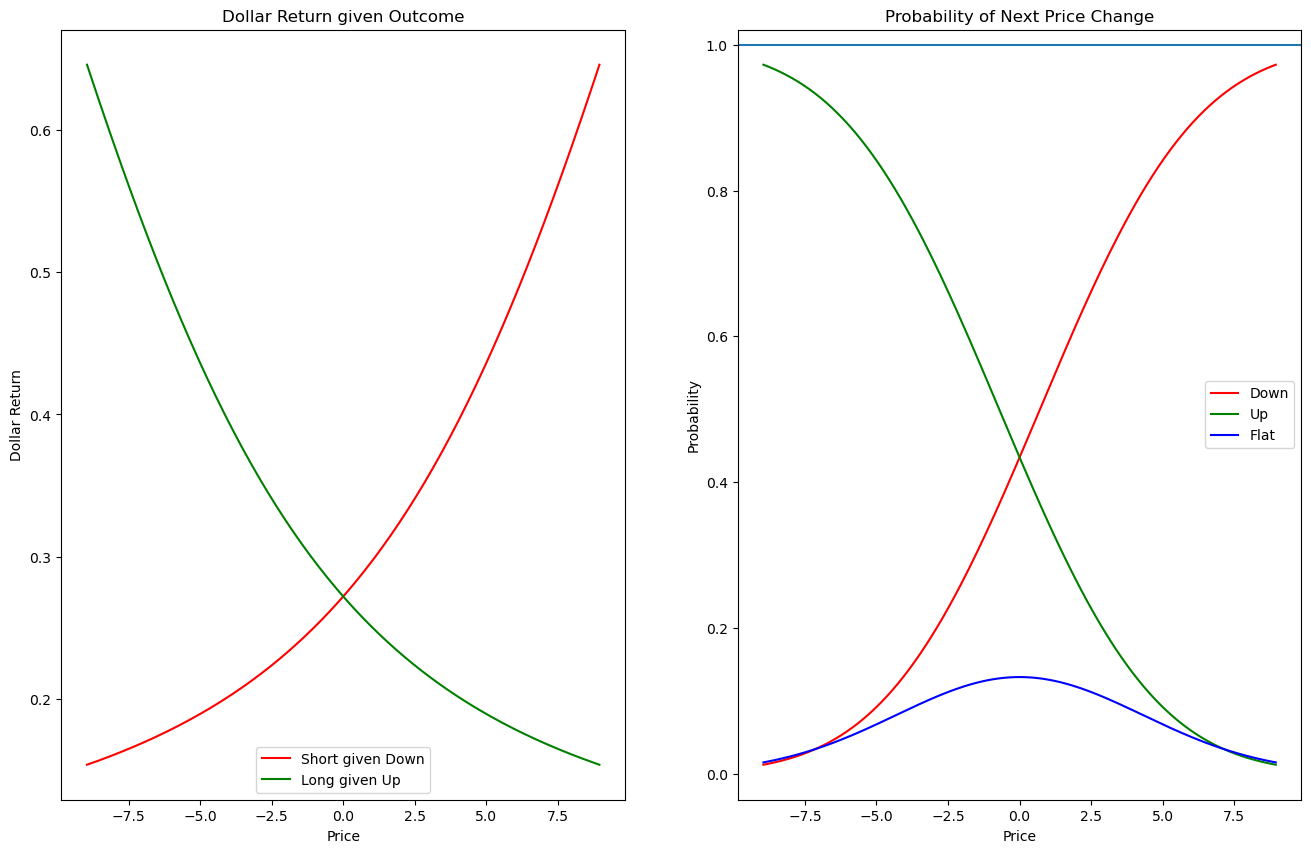

In [122]:
strat = MeanRevertingStrategy(pripro, 1, 100)

fig, axs = plt.subplots(1,2)

strat.plot_sizing_params(axs)

plt.show()

,PRICE,POS,CASH
0,0.05,-0.0,-0.0
1,0.35,-13.0,4.3
2,0.85,-78.0,47.5
3,0.75,-61.0,-11.9
4,0.85,-78.0,15.3
5,0.85,-78.0,0.0
6,0.45,-22.0,-31.8
7,0.45,-22.0,0.0
8,0.95,-97.0,62.0
9,0.25,-7.0,-50.9


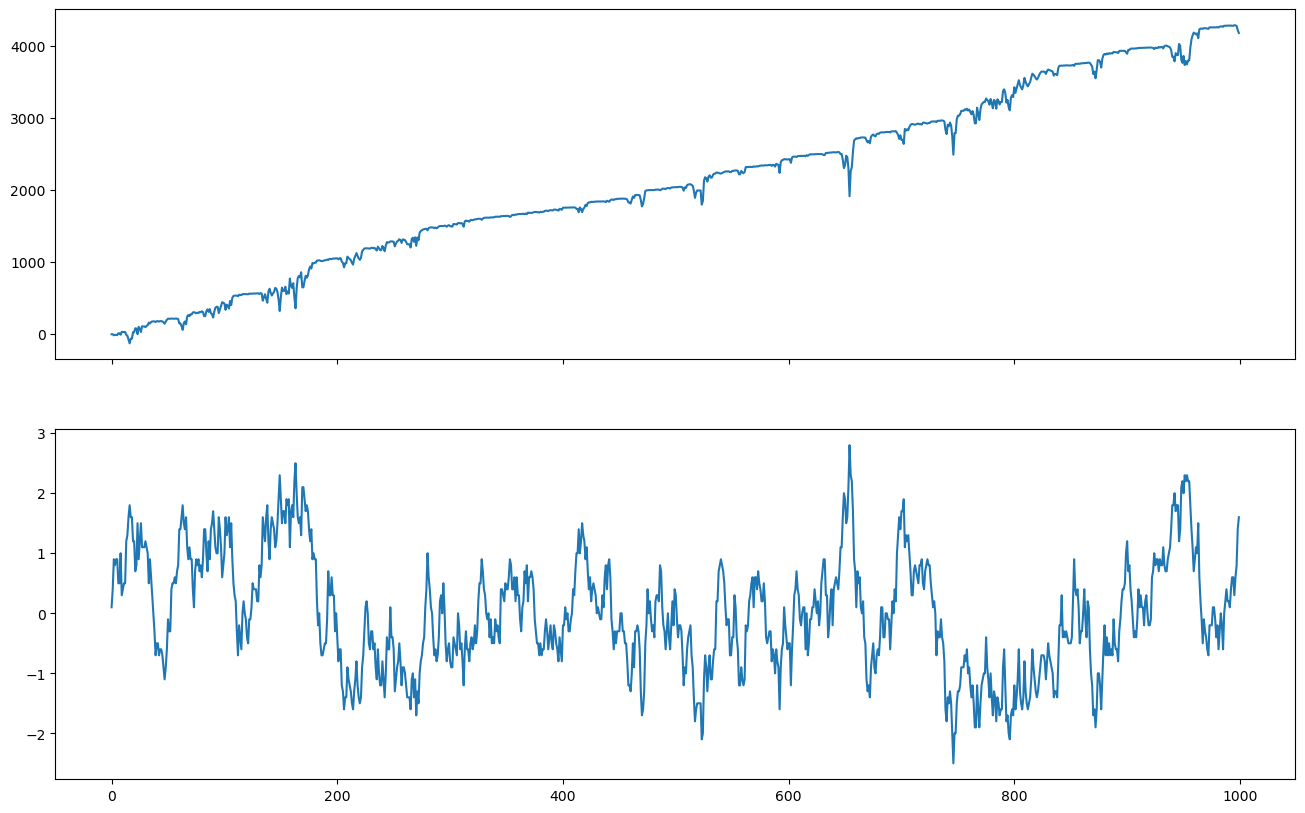

In [123]:
strat.backtest()
display(strat.trades.head(10))

fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(strat.trades["CASH"].cumsum() + strat.trades["PRICE"] * strat.trades["POS"])
axs[1].plot(strat.pripro.ask_price)

In [ ]:
strat.data

,BID,MID,ASK,EDO,EUP,PDO,PUP,TOT,KELLY,POS,N@BID,N@ASK
0,-9.0,-8.95,-8.9,0.153770,0.645917,0.012067,0.972676,0.984743,57.320795,5732.0,-0.0,-96.0
1,-8.9,-8.85,-8.8,0.154477,0.639833,0.012819,0.971174,0.983992,56.363719,5636.0,96.0,-95.0
2,-8.8,-8.75,-8.7,0.155191,0.633783,0.013611,0.969604,0.983214,55.410354,5541.0,95.0,-95.0
3,-8.7,-8.65,-8.6,0.155915,0.627766,0.014444,0.967963,0.982408,54.460703,5446.0,95.0,-95.0
4,-8.6,-8.55,-8.5,0.156647,0.621784,0.015322,0.966250,0.981572,53.514774,5351.0,95.0,-94.0
...,...,...,...,...,...,...,...,...,...,...,...,...
175,8.5,8.55,8.6,0.621784,0.156647,0.966250,0.015322,0.981572,-53.514774,-5351.0,94.0,-95.0
176,8.6,8.65,8.7,0.627766,0.155915,0.967963,0.014444,0.982408,-54.460703,-5446.0,95.0,-95.0
177,8.7,8.75,8.8,0.633783,0.155191,0.969604,0.013611,0.983214,-55.410354,-5541.0,95.0,-95.0
178,8.8,8.85,8.9,0.639833,0.154477,0.971174,0.012819,0.983992,-56.363719,-5636.0,95.0,-96.0


In [ ]:
strat.data.loc[(0 < strat.data["MID"]) & (strat.data["MID"] < 2)]

,BID,MID,ASK,EDO,EUP,PDO,PUP,TOT,KELLY,POS,N@BID,N@ASK
90,-3.197442e-14,0.05,0.1,0.273232,0.270932,0.438411,0.429231,0.867641,-0.002721,-0.0,2.0,-0.0
91,1.000000e-01,0.15,0.2,0.275566,0.268664,0.447624,0.420089,0.867713,-0.024487,-2.0,5.0,-2.0
92,2.000000e-01,0.25,0.3,0.277932,0.266427,0.456866,0.410990,0.867855,-0.067996,-7.0,6.0,-5.0
93,3.000000e-01,0.35,0.4,0.280332,0.264222,0.466131,0.401938,0.868069,-0.133201,-13.0,9.0,-6.0
94,4.000000e-01,0.45,0.5,0.282766,0.262049,0.475414,0.392939,0.868353,-0.220034,-22.0,11.0,-9.0
95,5.000000e-01,0.55,0.6,0.285234,0.259905,0.484711,0.383997,0.868708,-0.328403,-33.0,13.0,-11.0
96,6.000000e-01,0.65,0.7,0.287737,0.257792,0.494016,0.375116,0.869132,-0.458193,-46.0,15.0,-13.0
97,7.000000e-01,0.75,0.8,0.290276,0.255708,0.503324,0.366301,0.869625,-0.609270,-61.0,17.0,-15.0
98,8.000000e-01,0.85,0.9,0.292850,0.253654,0.512631,0.357556,0.870187,-0.781475,-78.0,19.0,-17.0
99,9.000000e-01,0.95,1.0,0.295461,0.251629,0.521931,0.348885,0.870815,-0.974632,-97.0,22.0,-19.0


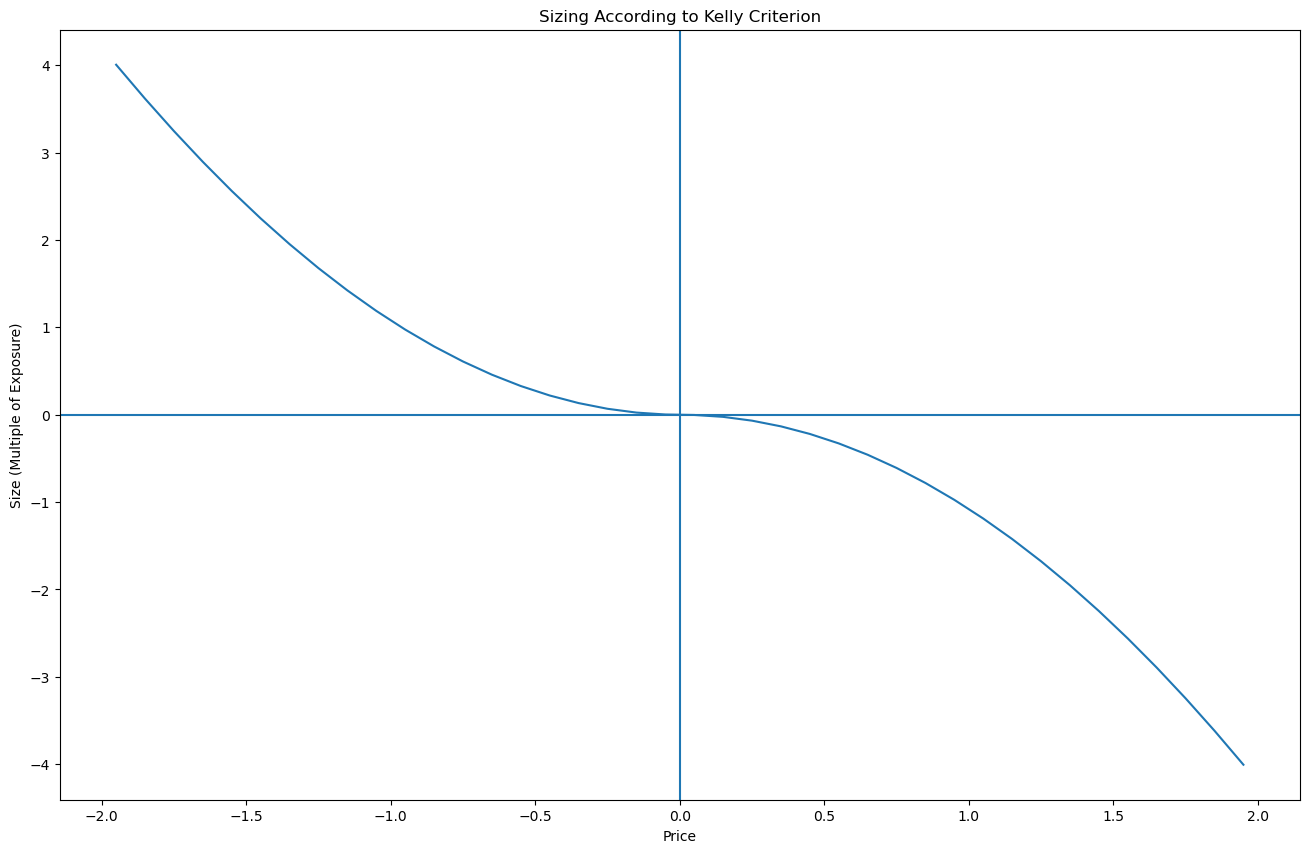

In [53]:
fig, axs = plt.subplots()

strat.plot_sizing_array(axs, np.abs(strat.data["MID"]-strat.pripro.dynamics.mu) < 2)

plt.show()

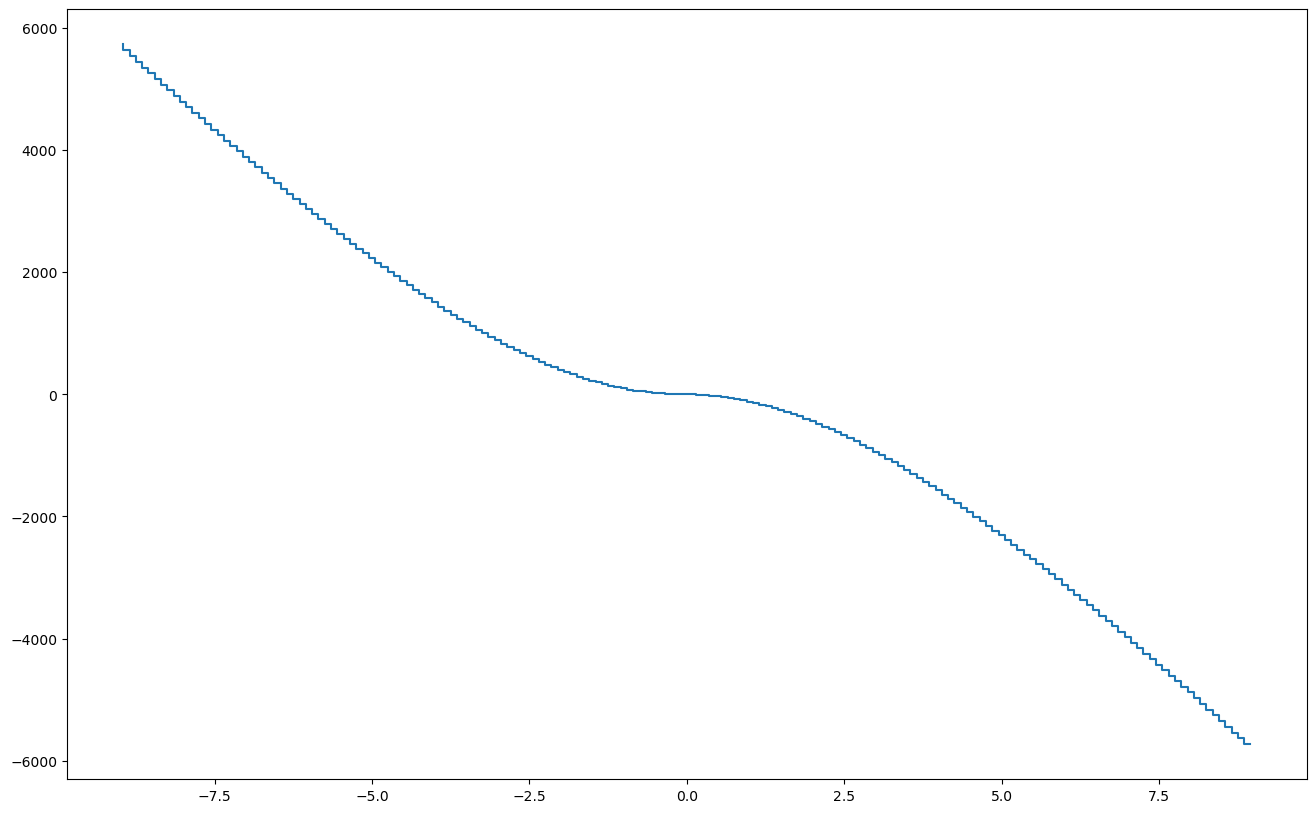

In [54]:
plt.step(strat.data["MID"], strat.data["POS"])

In [36]:
strat.data.iloc[(np.isclose(strat.data["MID"], -1.85))]

,BID,MID,ASK,EDO,EUP,PDO,PUP,TOT,KELLY,POS,N@BID,N@ASK
71,-1.9,-1.85,-1.8,0.234634,0.320657,0.274809,0.604495,0.879304,3.617324,196.0,9.0,-10.0


In [62]:
position_array = np.round((strat.kelly * strat.exposure) / np.abs(strat.mids))

quote_bids = np.zeros(position_array.shape)
quote_asks = np.zeros(position_array.shape)
quote_bids[1:] = position_array[:-1] - position_array[1:]
quote_asks[:-1] = position_array[1:] - position_array[:-1]

quote_bids

array([ 0.,  3.,  4.,  3.,  4.,  4.,  4.,  3.,  4.,  4.,  4.,  4.,  4.,
        5.,  4.,  4.,  4.,  5.,  4.,  5.,  4.,  5.,  5.,  4.,  5.,  5.,
        5.,  5.,  6.,  5.,  5.,  6.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  7.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,  7.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  9.,  8.,  9.,  9.,  9.,  9.,  9.,
        9., 10.,  9., 10., 10., 10.,  9., 10., 11., 10., 10., 10., 11.,
       10., 11., 10., 11., 11., 11., 10., 11., 11., 11., 11., 11., 10.,
       11., 11., 11., 11., 11., 10., 11., 11., 11., 10., 11., 10., 11.,
       10., 10., 10., 11., 10.,  9., 10., 10., 10.,  9., 10.,  9.,  9.,
        9.,  9.,  9.,  9.,  8.,  9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        7.,  8.,  7.,  7.,  7.,  7.,  7.,  7.,  6.,  7.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  5.,  6.,  5.,  5.,  6.,  5.,  5.,  5.,
        5.,  4.,  5.,  5.,  4.,  5.,  4.,  5.,  4.,  4.,  4.,  5.,  4.,
        4.,  4.,  4.,  4.,  3.,  4.,  4.,  4.,  3.,  4.,  3.])

In [11]:
print(p[:5], q[:5], a[:5], b[:5], sep='\n')
print("")
print(p[-5:], q[-5:], a[-5:], b[-5:], sep='\n')

[0.98774638 0.98697297 0.98615711 0.98529691 0.98439041]
[0.01225362 0.01302703 0.01384289 0.01470309 0.01560959]
[0.14644767 0.13432749 0.12415319 0.11549246 0.10803223]
[0.615159   0.55637677 0.50702624 0.46501201 0.42881669]

[0.01560959 0.01470309 0.01384289 0.01302703 0.01225362]
[0.98439041 0.98529691 0.98615711 0.98697297 0.98774638]
[0.03351936 0.03366039 0.03380175 0.03394341 0.03408533]
[0.00844457 0.00836004 0.00827688 0.00819505 0.00811451]


In [ ]:
asdf

In [ ]:
from abc import ABC, abstractclassmethod
from numpy.typing import NDArray


def kelly_criterion(p: float | NDArray, q: float | NDArray, a: float | NDArray, b: float | NDArray) -> float | NDArray:
    return p/a - q/b

class TradingStrategy(ABC):

    exposure: float

    @abstractclassmethod
    def backtest(self):
        pass

    @abstractclassmethod
    def size_position(self):
        pass


class MeanRevertingStrategy(TradingStrategy):
    """Trades a PriceProcess based on understanding the OU Process's dynamics"""

    def __init__(self, pripro: PriceProcess, exposure: int = int(1e4), z_score: float = 3):
        self.pripro = pripro
        self.exposure = exposure

        self.generate_sizing_factors(z_score)
        self.generate_kelly()

    def backtest(self):
        self.positions = np.zeros(self.pripro.time.shape[0])

        for time in self.pripro.time:
            mid = pripro.mid_price[time]

    def size_position(self, mid: float):
        pass

    def generate_sizing_factors(self, z_score: float) -> None:
        self.mids = np.arange(X0 - z_score * self.pripro.dynamics.sigma,
                              X0 + z_score * self.pripro.dynamics.sigma,
                              self.pripro.ticksize) + self.pripro.ticksize / 2

        self.edo = np.zeros(self.mids.shape)
        self.eup = np.zeros(self.mids.shape)
        self.pdo = np.zeros(self.mids.shape)
        self.pup = np.zeros(self.mids.shape)

        for i in range(self.mids.shape[0]):
            mid = self.mids[i]
            bid = round_to(mid, TICKSIZE)
            ask = bid + TICKSIZE

            drift = self.pripro.dynamics.theta * (self.pripro.dynamics.mu - mid) * self.pripro.dynamics.deltat

            self.pdo[i] = stats.norm.cdf(bid, mid+drift, std)
            self.pup[i] = stats.norm.sf(ask,  mid+drift, std)

            self.edo[i] = mid - stats.norm.expect(loc=mid+drift, scale=std, ub=bid) / self.pdo[i]
            self.eup[i] = stats.norm.expect(loc=mid+drift, scale=std, lb=ask) / self.pup[i] - mid

        self.tot = self.pdo + self.pup

    def generate_kelly(self):
        p = self.pup / self.tot
        q = self.pdo / self.tot

        b = self.eup / np.abs(self.mids)
        a = self.edo / np.abs(self.mids)

        self.kelly = kelly_criterion(p, q, a, b)

    def plot_sizing_params(self, axis: plt.Axes):
        axis[0].plot(self.mids, self.edo, color='r', label="Short given Down")
        axis[0].plot(self.mids, self.eup, color='g', label="Long given Up")
        axis[0].legend()
        axis[0].set(title="Dollar Return given Outcome", xlabel="Price", ylabel="Dollar Return")

        axis[1].plot(self.mids, self.pdo, color='r', label="Down")
        axis[1].plot(self.mids, self.pup, color='g', label="Up")
        axis[1].plot(self.mids, 1-self.tot, color='b', label="Flat")
        axis[1].axhline(1)
        axis[1].legend()
        axis[1].set(title="Probability of Next Price Change", xlabel="Price", ylabel="Probability")

    def plot_sizing_array(self, axis: plt.Axes, mask: None | NDArray = None) -> None:
        if mask is None:
            mask = np.ones(self.kelly.shape).astype(bool)
        
        axis.plot(self.mids[mask], self.kelly[mask])
        axis.axvline(X0)
        axis.axhline(0)
        axis.set(title="Sizing According to Kelly Criterion", xlabel="Price", ylabel="Size (Multiple of Exposure)")